# <center>Transformer from scratch１：モデルの実装の仕方</center>
## <center>最終更新日(だいたい完成版)：2021.5/12</center>

自己アテンションに基づくTransformerアーキテクチャをtf.Kerasで実装するノートブックです。同じような内容は

https://www.tensorflow.org/tutorials/text/transformer?hl=ja

にあります。また、スクラッチ実装をしなくても多くのライブラリでは簡単にSelf-Attention層が利用できます。しかしちゃんとTransformerを理解したりTransformerベースのモデルを開発したいなら、スクラッチ実装の経験がないといけないと思いますので、勉強していきましょう！

[参考文献]

https://arxiv.org/pdf/1706.03762.pdf


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

# 1. 位置エンコーディング(Position Encoding)

自己アテンションの仕組みを思い出してみましょう。それぞれのトークンをキー・クエリとする重要度重みを計算し、それによりトークンの重みつき平均を計算することで特徴量を作っていました

$$
X_{t,:}^{next}=\sum_{t'} Attention_{(k,q)=(t,t')}\, X_{t',:}
$$

したがって<b>元々のトークンの並び順の情報は、計算に一切反映されません</b>。これはRNNとの大きな違いです。

もちろん言語のような系列データでは、トークンの並び順も重要な情報を担っているはずです。この情報をモデル計算に反映させるための標準的な手法が位置エンコーディング(position encoding)です。
位置(時刻)$t$のトークンベクトル$X_{t,:}\in\mathbb{R}^d$に対して、
その位置$t$情報を表現したベクトル$PE_{t,:}$を加算することで、トークンに位置情報を挿入するのがこの手法です：

$$
X_{t,:} \leftarrow X_{t,:} + PE_{t,:}.
$$

ただし$d$はTransformerモデルの埋め込み次元(トークンベクトルの次元)です。位置情報$PE_{t,:}$は位置エンコーディングベクトルと呼ばれるもので、予め設計した定数を使う場合や、このベクトル自体も学習する場合などがあります（さらに絶対位置エンコーディングや相対位置エンコーディングなどの概念があります）。

ここではオリジナルの定数の(絶対)位置エンコーディングを使いましょう。
このエンコーディングは、各位置$t$とベクトルの要素$i$に対して、次のような定数成分を割り振る手法です：

$$
PE_{t,i}
=
\left\{\begin{array}{l}
\sin
\big(
\frac{t}{10000^{{2k}/{d}}}
\big)
\;\;\;for\;\;i=2k
\\
\cos
\big(
\frac{t}{10000^{{2k}/{d}}}
\big)
\;\;\;for\;\;i=2k+1
\end{array}\right.
$$

まとめると次のように表記できます：

$$
PE_{t,i}
=
\sin
\left(
\frac{t}{10000^{{2(i//2)}/{d}}}
+\frac{\pi}{2}(i\%2)
\right)
$$

したがって与えられたサイズに対してこの$PE$を配列として与える関数は、次のように実装できます：

In [2]:
# 各位置でエンコーディングを計算
def positional_encoding_function(t, i, d):
    theta = t / 10000**(2*(i//2)/d) + np.pi/2 * (i%2)
    return np.sin(theta)

# (1, T, d)の配列の形でエンコーディングを返す
def positional_encoding(T, d):
    dd, TT = np.meshgrid(np.arange(d), np.arange(T))
    encoding = positional_encoding_function(TT, dd, d)
    encoding = encoding[np.newaxis,:,:]
    return encoding

１つエンコーディング配列を生成して可視化すると

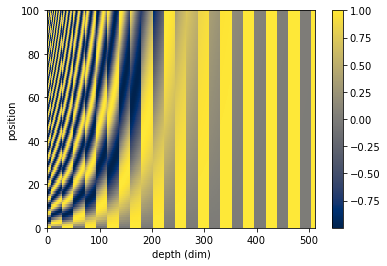

In [3]:
pos_encoding = positional_encoding(T=100, d=512)

plt.pcolormesh(pos_encoding[0], cmap='cividis')
plt.xlabel('depth (dim)')
plt.ylabel('position')
plt.colorbar()
plt.show()

この位置埋め込みを足す操作を、層として実装しておく：

In [4]:
class PositionalEncoding(layers.Layer):
    def __init__(self, max_seq_len, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.pos_encoding = positional_encoding(max_seq_len, d_model)

    def call(self, inputs):
        input_dtype = inputs.dtype
        pos_encoding = self.pos_encoding
        pos_encoding = tf.cast(pos_encoding, dtype=input_dtype)
        # rescale
        inputs *= tf.math.sqrt(tf.cast(self.d_model, dtype=input_dtype))

        return inputs + pos_encoding

モデルインスタンスを作って実装を確認してみよう。文字列入力を

埋め込み→位置埋め込み→ドロップアウト

と処理する、Transformerのはじめ数層をモデルインスタンスとして作ってみると

In [5]:
source_vocab_size = 100000
max_seq_len = 100
d_model = 512
do_rate = 0.2

encoder_input = layers.Input(shape=(max_seq_len,), name='encoder_inputs')

# Embedding
x = layers.Embedding(source_vocab_size, d_model)(encoder_input)
x = PositionalEncoding(max_seq_len, d_model)(x)
x = layers.Dropout(do_rate)(x)

model = tf.keras.models.Model(inputs=encoder_input, outputs=x, name='encoder')

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 512)          51200000  
_________________________________________________________________
positional_encoding (Positio (None, 100, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 512)          0         
Total params: 51,200,000
Trainable params: 51,200,000
Non-trainable params: 0


## 単調性

さてゼミで話題になった埋め込みベクトルの距離の関係を確認しておく。
トータル100文字の入力に対する位置埋め込みの場合、はじめのトークンの位置埋め込みベクトルとその後の99文字の位置埋め込みベクトルの間の距離の計算はNumpyの簡単な練習問題。例えば次のようにできる：

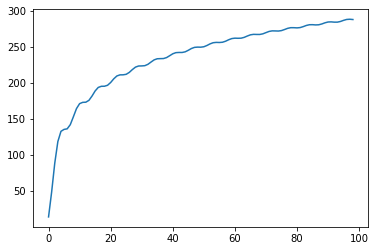

In [6]:
pos_encoding = positional_encoding(T=100, d=512)
distances = np.sum((pos_encoding[0,1:,:] - pos_encoding[0,0:1,:])**2, axis=-1) # 距離の二乗

plt.plot(distances)
plt.show()

確かにユークリッド距離（の二乗）は単調に増加する。一応見ておくとグラフの微係数は

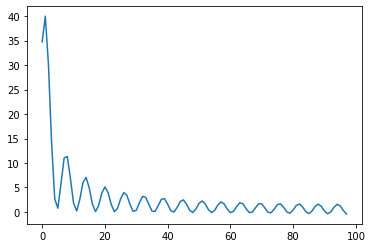

In [7]:
plt.plot(distances[1:]-distances[:-1])
plt.show()

ベクトル間の角度（コサイン）もどんどん大きくなってゆく（ノルム自体が一定なので、上の結果と同じこと）

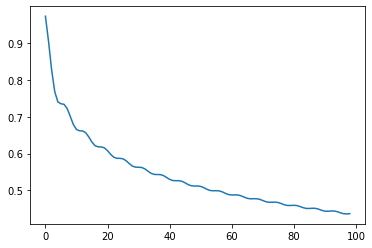

In [8]:
norm_0 = np.sqrt(np.sum((pos_encoding[0,0:1,:])**2, axis=-1))
norm_1 = np.sqrt(np.sum((pos_encoding[0,1:,:])**2, axis=-1))

cosines = np.sum((pos_encoding[0,1:,:]*pos_encoding[0,0:1,:]), axis=-1)/(norm_0*norm_1+1e-10)

plt.plot(cosines)
plt.show()

また面白いことに、隣接ベクトル間の距離は一定（埋め込みベクトル間の距離スケールは、トークン位置を平行移動しても変わらない）：

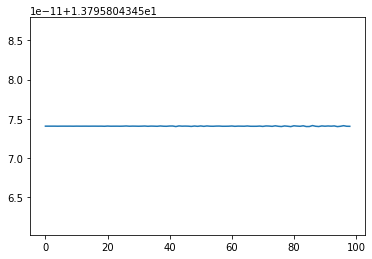

In [9]:
adj_distances = np.sum((pos_encoding[0,1:,:] - pos_encoding[0,:-1,:])**2, axis=-1)

plt.plot(adj_distances)
plt.show()

まぁこの結果自体は三角関数の性質からすぐわかる気もするが。

# 2. 自己アテンション層とマルチヘッド化

まず（シングルヘッドの）自己アテンション層を実装する。基底Layerクラスを継承して１つのlayerとしてまとめて実装するには、順伝播則を`call`部分に実装すればいいので、次のようになる：

In [10]:
class SelfAttention(layers.Layer):
    def __init__(self, d_model):
        super(SelfAttention, self).__init__()
        self.d_model = d_model

        self.dense_q = layers.Dense(d_model, use_bias=False)
        self.dense_k = layers.Dense(d_model, use_bias=False)
        self.dense_v = layers.Dense(d_model, use_bias=False)
        self.dense_o = layers.Dense(d_model, use_bias=False)

    def call(self, x_q, x_k, x_v, mask):
        
        q = self.dense_q(x_q) # (N, d_q = max_seq_len, d_model)
        k = self.dense_k(x_k) # (N, d_k = max_seq_len, d_model)
        v = self.dense_v(x_v) # (N, d_v = d_k = max_seq_len, d_model)

        d_k = tf.shape(k)[-1]
        k_dtype = k.dtype # 普段はfloat32
        scale = 1/tf.math.sqrt(tf.cast(d_k, k_dtype))

        logit = tf.matmul(q, k, transpose_b=True) # (N, max_seq_len, 'd_model')@(N, 'd_model', max_seq_len)
                                                  #  -> (N, max_seq_len, max_seq_len)
        logit *= scale

        if mask is not None:
            logit += mask*k_dtype.min # マスキングする要素には-∞を他しておく
        
        attention_weight = tf.nn.softmax(logit, axis=-1) # (N, max_seq_len, 'max_seq_len')の最後の軸'max_seq_len'に沿ってsoftmax
        attention_output = tf.matmul(attention_weight, v) # (N, max_seq_len, 'max_seq_len')@(N, 'max_seq_len', d_model)
                                                          #  -> (N, max_seq_len, d_model)
        attention_output = self.dense_o(attention_output)

        return attention_output, attention_weight

ただし`call`の引数に与えた`mask`は、後で消さなくてはならないトークンをmask outするのに使うことになるのでとりあえず気にしない。

この層を使うと、Transformerのはじめの数層分は次のようになる（先ほどの1節のモデルインスタンスに、自己アテンションのモジュールが加わった）：

In [11]:
encoder_input = layers.Input(shape=(max_seq_len,), name='encoder_input')

# Embedding
x = layers.Embedding(source_vocab_size, d_model)(encoder_input)
x = PositionalEncoding(max_seq_len, d_model)(x)
x = layers.Dropout(do_rate)(x)

# SAモジュール
# 例えばmask_eg = np.array([[0]*50 + [1]*50])をmaskに渡しても動作。
x_sa, _ = SelfAttention(d_model)(x,x,x,mask=None)
x = layers.Add()([x,x_sa])
x = layers.LayerNormalization(epsilon=1e-6)(x)

model = tf.keras.models.Model(inputs=encoder_input, outputs=x, name='encoder')

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 512)     51200000    encoder_input[0][0]              
__________________________________________________________________________________________________
positional_encoding_1 (Position (None, 100, 512)     0           embedding_1[0][0]    

実際にはマルチヘッド化した自己アテンション層を使うので、実装を拡張しておく。`n_heads`が文字通りヘッド数である：

In [12]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, n_heads, d_model):
        super(MultiHeadSelfAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model

        assert self.d_model % self.n_heads == 0, 'n_headsはd_modelの因数'

        self.d = self.d_model // self.n_heads

        self.dense_q = layers.Dense(d_model, use_bias=False)
        self.dense_k = layers.Dense(d_model, use_bias=False)
        self.dense_v = layers.Dense(d_model, use_bias=False)
        self.dense_o = layers.Dense(d_model, use_bias=False)

    def call(self, x_q, x_k, x_v, mask):
        
        q = self.dense_q(x_q) # (N, max_seq_len, d_model)
        k = self.dense_k(x_k) # (N, max_seq_len, d_model)
        v = self.dense_v(x_v) # (N, max_seq_len, d_model)

        max_seq_len = tf.shape(k)[1]
        
        # 以下で長さd_modelの軸をn_headsの軸とdの軸に分ける
        q = self.split_to_heads(q, max_seq_len) # (N, n_heads, max_seq_len, d)
        k = self.split_to_heads(k, max_seq_len) # (N, n_heads, max_seq_len, d)
        v = self.split_to_heads(v, max_seq_len) # (N, n_heads, max_seq_len, d)

        # 以下では長さdの軸に対して、シングルヘッドの場合の行列演算を施してゆく
        logit = tf.matmul(q, k, transpose_b=True) # (N, n_heads, max_seq_len, 'd')@(N, n_heads, 'd', max_seq_len)
                                                  #  -> (N, n_heads, max_seq_len, max_seq_len)

        d_k = tf.shape(k)[-1]
        k_dtype = k.dtype
        scale = 1/tf.math.sqrt(tf.cast(d_k, k_dtype))
        logit *= scale

        if mask is not None:
            logit += mask*k_dtype.min # (1,1,max_seq_len, max_seq_len)をbroadcast
        
        attention_weight = tf.nn.softmax(logit, axis=-1) # (N, n_heads, max_seq_len, max_seq_len)

        #attention_output = tf.matmul(attention_weight, v) # (N, n_heads, max_seq_len, d)
        #attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3]) # (N, max_seq_len, n_heads, d)
        attention_output = tf.einsum('nhst,nhtd->nshd', attention_weight, v) # (N, max_seq_len, n_heads, d)

        attention_output = tf.reshape(attention_output, (-1, max_seq_len, self.n_heads*self.d)) # (N, max_seq_len, d_model)

        attention_output = self.dense_o(attention_output)

        return attention_output, attention_weight

    def split_to_heads(self, x, max_seq_len):
        x = tf.reshape(x, (-1, max_seq_len, self.n_heads, self.d)) # (N, max_seq_len, d_model) -> (N, max_seq_len, n_heads, d)
        x = tf.transpose(x, perm=[0, 2, 1, 3]) # (N, max_seq_len, n_heads, d) -> (N, n_heads, max_seq_len, d)
        return x

先ほどの「一部分Transformer」をマルチヘッド化してみると

In [13]:
n_heads = 8

encoder_input = layers.Input(shape=(max_seq_len,), name='encoder_input')

x = layers.Embedding(source_vocab_size, d_model)(encoder_input)
x = PositionalEncoding(max_seq_len, d_model)(x)
x = layers.Dropout(do_rate)(x)

x_sa, _ = MultiHeadSelfAttention(n_heads, d_model)(x,x,x,mask=None)
x_sa = layers.Dropout(do_rate)(x_sa)
x = layers.Add()([x,x_sa])
x = layers.LayerNormalization(epsilon=1e-6)(x)

model = tf.keras.models.Model(inputs=encoder_input, outputs=x, name='encoder')

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 512)     51200000    encoder_input[0][0]              
__________________________________________________________________________________________________
positional_encoding_2 (Position (None, 100, 512)     0           embedding_2[0][0]    

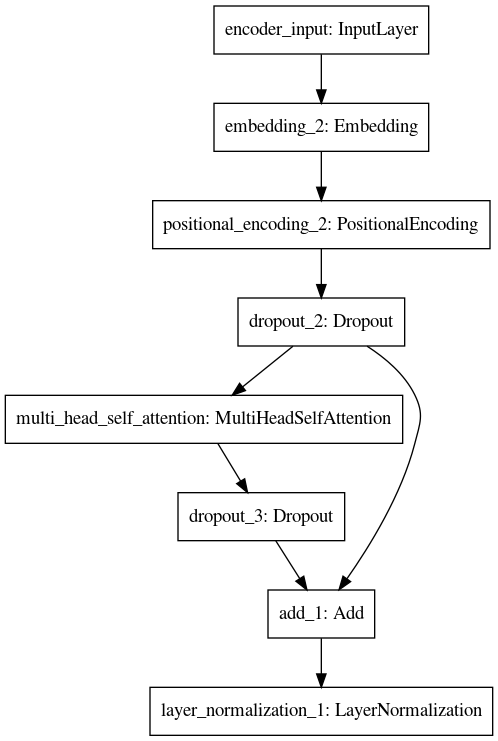

In [14]:
from tensorflow.keras.utils import plot_model
import pydot

plot_model(model)

この中のMHSA->Dropout->Residual->LayerNormは毎回出てくる組み合わせなので、これをひとまとめにしておく：

In [15]:
class MHSAModule(layers.Layer):
    def __init__(self, source_vocab_size, max_seq_len, d_model, n_heads, do_rate):
        super(MHSAModule, self).__init__()
        self.mhsa = MultiHeadSelfAttention(n_heads, d_model)
        self.dropout = layers.Dropout(do_rate)
        self.add = layers.Add()
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training, mask):
        x, att = self.mhsa(inputs, inputs, inputs, mask)
        x = self.dropout(x, training=training)
        x = self.add([x,inputs])
        x = self.norm(x)
        return x, att

モデルインスタンスを作って実装を確認：

In [16]:
encoder_input = layers.Input(shape=(max_seq_len,), name='encoder_input')

x = layers.Embedding(source_vocab_size, d_model)(encoder_input)
x = PositionalEncoding(max_seq_len, d_model)(x)
x = layers.Dropout(do_rate)(x)

x, _ = MHSAModule(source_vocab_size, max_seq_len, d_model, n_heads, do_rate)(x, training=False, mask=None)

model = tf.keras.models.Model(inputs=encoder_input, outputs=x, name='encoder')

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 512)          51200000  
_________________________________________________________________
positional_encoding_3 (Posit (None, 100, 512)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
mhsa_module 

# 3. Pointwise Feed Forward層

Pointwise Feed Forward層は、各トークンに同じアフィン変換を作用させる層であった。Transformerにおける対応するモジュールは、このような層二つからなり、一回目のアフィン変換の直後だけReLU活性化関数を作用させる仕様である：

(N, max_seq_len, d_model)

↓ shape of W: (d_model, d_ff)

↓ relu

(N, max_seq_len, d_ff)

↓ shape of W:(d_ff, d_model)

(N, max_seq_len, d_model)

KerasなどのライブラリのDense（Linear）層は、高階テンソル入力に作用させると最後の軸に関してのみアフィン変換するので、今の我々の軸定義なら次のように<b>単にDenseを作用させるだけでpoint-wiseになることに気づくことが実装のポイント</b>である。

従って、先ほどのミニモデルにこの層を加えてミニチュアTrasnformerモデルを実装すると

In [17]:
d_ff = 2048

encoder_input = layers.Input(shape=(max_seq_len,), name='encoder_input')

# Embedding
x = layers.Embedding(source_vocab_size, d_model)(encoder_input)
x = PositionalEncoding(max_seq_len, d_model)(x)
x = layers.Dropout(do_rate)(x)

# SAモジュール
x_sa, _ = MultiHeadSelfAttention(n_heads, d_model)(x,x,x,mask=None)
x_sa = layers.Dropout(do_rate)(x_sa)
x = layers.Add()([x,x_sa])
x = layers.LayerNormalization(epsilon=1e-6)(x)

# PWFFモジュール
x_ff = layers.Dense(d_ff, activation='relu')(x)
x_ff = layers.Dense(d_model)(x_ff)
x_ff = layers.Dropout(do_rate)(x_ff)
x = layers.Add()([x, x_ff])
x = layers.LayerNormalization(epsilon=1e-6)(x)

model = tf.keras.models.Model(inputs=encoder_input, outputs=x, name='encoder')

model.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 512)     51200000    encoder_input[0][0]              
__________________________________________________________________________________________________
positional_encoding_4 (Position (None, 100, 512)     0           embedding_4[0][0]                
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 100, 512)     0           positional_encoding_4[0][0]      
____________________________________________________________________________________________

一応モデルの構造も見ておくと

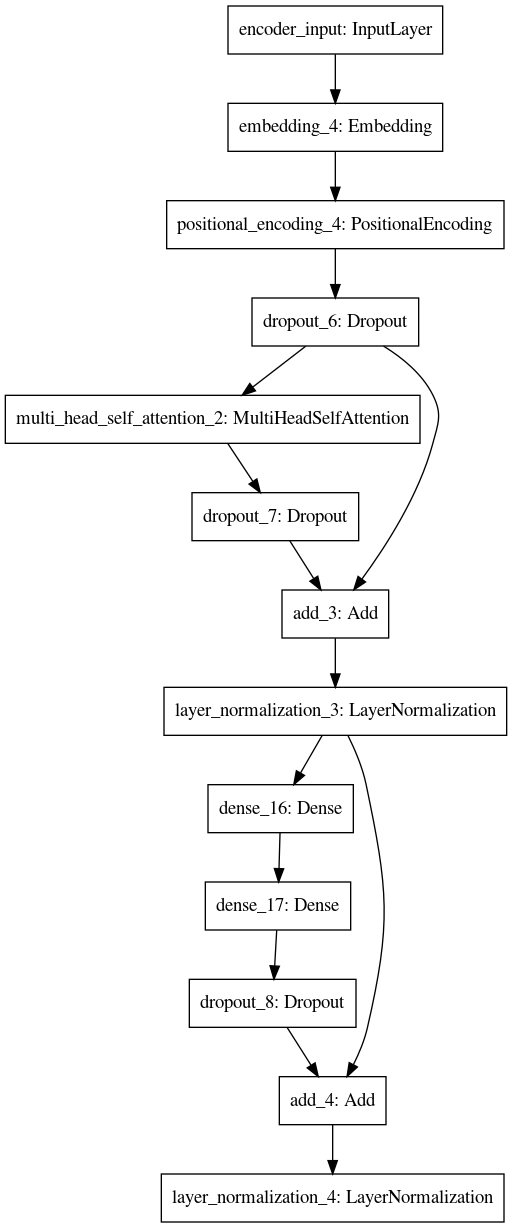

In [18]:
plot_model(model)

このFF→FF→Dropout→Res→Normの流れも繰り返し登場するので、モジュールにしておく：

In [19]:
class PointWiseFeedForwardModule(layers.Layer):
    def __init__(self, d_model, d_ff, do_rate):
        super(PointWiseFeedForwardModule, self).__init__()
        self.pwff_1 = layers.Dense(d_ff, activation='relu')
        self.pwff_2 = layers.Dense(d_model)
        self.dropout = layers.Dropout(do_rate)
        self.add = layers.Add()
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training):
        x = self.pwff_1(inputs)
        x = self.pwff_2(x)
        x = self.dropout(x, training=training)
        x = self.add([x,inputs])
        x = self.norm(x)
        return x

モデルインスタンスを作って実装を確認：

In [20]:
encoder_input = layers.Input(shape=(max_seq_len,), name='encoder_input')

x = layers.Embedding(source_vocab_size, d_model)(encoder_input)
x = PositionalEncoding(max_seq_len, d_model)(x)
x = layers.Dropout(do_rate)(x)

# SA
x, _ = MHSAModule(source_vocab_size, max_seq_len, d_model, n_heads, do_rate)(x, training=False, mask=None)
# PWFF
x = PointWiseFeedForwardModule(d_model, d_ff, do_rate)(x, training=False)

model = tf.keras.models.Model(inputs=encoder_input, outputs=x, name='encoder')

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 512)          51200000  
_________________________________________________________________
positional_encoding_5 (Posit (None, 100, 512)          0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 512)          0         
_________________________________________________________________
mhsa_module_

# 4. 自己アテンションモジュールとエンコーダ

以上でSAとFFのカタマリが実装できたが、これらはTransformerの中では交互に登場する。そこれMHSA→FFの組み合わせも１つにまとめておく：

In [21]:
class EncoderModule(layers.Layer):
    def __init__(self, source_vocab_size, max_seq_len, d_model, n_heads, do_rate):
        super(EncoderModule, self).__init__()
        self.mhsa = MHSAModule(source_vocab_size, max_seq_len, d_model, n_heads, do_rate)
        self.pwff = PointWiseFeedForwardModule(d_model, d_ff, do_rate)

    def call(self, inputs, training, mask):
        x, att = self.mhsa(inputs, mask, training)
        x = self.pwff(x, training)
        return x, att

ただしデコーダのためのモジュールはマスクの扱いがもう少しややこしくなるので、後で別に実装する。

今作ったモジュールの実装を、モデルインスタンスを作って動作確認しよう：

In [22]:
encoder_input = layers.Input(shape=(max_seq_len,), name='encoder_input')

x = layers.Embedding(source_vocab_size, d_model)(encoder_input)
x = PositionalEncoding(max_seq_len, d_model)(x)
x = layers.Dropout(do_rate)(x)

x, _ = EncoderModule(source_vocab_size, max_seq_len, d_model, n_heads, do_rate)(x, training=False, mask=None)

model = tf.keras.models.Model(inputs=encoder_input, outputs=x, name='encoder')

model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 512)          51200000  
_________________________________________________________________
positional_encoding_6 (Posit (None, 100, 512)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 512)          0         
_________________________________________________________________
encoder_modu

これでTransformerをだいぶすっきりと実装することができる。エンコーダ自体は次のように実装できる：

In [23]:
class Encoder(layers.Layer):
    def __init__(self, n_layers, source_vocab_size, max_seq_len, d_model, n_heads, do_rate):
        super(Encoder, self).__init__()
        self.source_vocab_size = source_vocab_size
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.do_rate = do_rate
        self.do = layers.Dropout(do_rate)

        self.embedding = layers.Embedding(source_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(max_seq_len, d_model)
        self.mhsa_modules = [EncoderModule(source_vocab_size, max_seq_len, d_model, n_heads, do_rate) for _ in range(n_layers)]

    def call(self, inputs, training, mask_enc):
        x = self.embedding(inputs)
        x = self.pos_encoding(x)
        x = self.do(x, training=training)
        attention_weights = []
        for module in self.mhsa_modules:
            x, att = module(x, training, mask_enc)
            attention_weights.append(att)
        return x, attention_weights

モデルインスタンスを作って実装を確認：

In [24]:
n_layers = 4

encoder_input = layers.Input(shape=(max_seq_len,), name='encoder_input')
x, _ = Encoder(n_layers, source_vocab_size, max_seq_len, d_model, n_heads, do_rate)(encoder_input, training=False, mask_enc=None)

encoder_model = tf.keras.models.Model(inputs=encoder_input, outputs=x, name='encoder')

encoder_model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 100)]             0         
_________________________________________________________________
encoder (Encoder)            ((None, 100, 512), [(None 63801344  
Total params: 63,801,344
Trainable params: 63,801,344
Non-trainable params: 0
_________________________________________________________________


# 5. 自己アテンションモジュールとデコーダ

デコーダの実装もエンコーダと大体同じです。ただし、エンコーダ出力をキー・バリューに使う自己アテンションモジュールも必要であることを思い出しましょう。

従ってデコーダで使うためのMHSAモジュールも実装しておきます：


In [25]:
class MHSAModuleDec(layers.Layer):
    def __init__(self, source_vocab_size, max_seq_len, d_model, n_heads, do_rate):
        super(MHSAModuleDec, self).__init__()
        self.mhsa = MultiHeadSelfAttention(n_heads, d_model)
        self.dropout = layers.Dropout(do_rate)
        self.add = layers.Add()
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs, context, training, mask):
        x, att = self.mhsa(inputs, context, context, mask)
        x = self.dropout(x, training=training)
        x = self.add([x,inputs])
        x = self.norm(x)
        return x, att

エンコーダに使ったMHSAとこの新しいMHSAモジュールを積層することでデコーダモジュールも作れます。このモジュールの順伝播（`call()`）部分は、入力としてエンコーダ出力（日英翻訳なら日本語文の入力をデコーダで処理したもの）と、デコーダ自体の入力（日英翻訳なら英語文の入力場所）の二つの入力テンソルを受け取ることに注意しましょう：

In [26]:
class DecoderModule(layers.Layer):
    def __init__(self, source_vocab_size, max_seq_len, d_model, n_heads, do_rate):
        super(DecoderModule, self).__init__()
        self.mhsa1 = MHSAModule(source_vocab_size, max_seq_len, d_model, n_heads, do_rate)
        self.mhsa2 = MHSAModuleDec(source_vocab_size, max_seq_len, d_model, n_heads, do_rate)
        self.pwff1 = PointWiseFeedForwardModule(d_model, d_ff, do_rate)
        self.pwff2 = PointWiseFeedForwardModule(d_model, d_ff, do_rate)

    def call(self, inputs, enc_outputs, training, mask, mask_look_ahead):
        x, att1 = self.mhsa1(inputs, training, mask)
        # 修正！！！
        x = self.pwff1(x, training)
        x, att2 = self.mhsa2(x, enc_outputs, training, mask_look_ahead)
        x = self.pwff2(x, training)
        return x, att1, att2

あとはこのモジュールを積層してデコーダの出来上がりです：

In [27]:
class Decoder(layers.Layer):
    def __init__(self, n_layers, target_vocab_size, max_seq_len, d_model, n_heads, do_rate):
        super(Decoder, self).__init__()
        self.target_vocab_size = target_vocab_size
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.do_rate = do_rate
        self.do = layers.Dropout(do_rate)

        self.embedding = layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(max_seq_len, d_model)
        self.mhsa_modules = [DecoderModule(source_vocab_size, max_seq_len, d_model, n_heads, do_rate) for _ in range(n_layers)]

    def call(self, inputs, enc_outputs, training, mask_dec, mask_look_ahead):
        x = self.embedding(inputs)
        x = self.pos_encoding(x)
        x = self.do(x, training=training)
        attention_weights = []
        for module in self.mhsa_modules:
            x, att1, att2 = module(x, enc_outputs, training, mask_dec, mask_look_ahead)
            attention_weights += [[att1, att2]]
        return x, attention_weights
    
    

最後にまたモデルインスタンスを作って確認しましょう：

In [28]:
decoder_input = layers.Input(shape=(max_seq_len,), name='decoder_input')
encoder_output = layers.Input(shape=(max_seq_len, d_model), name='encoder_input')

x, att = Decoder(n_layers, source_vocab_size, max_seq_len, d_model, n_heads, do_rate)(decoder_input, encoder_output, training=False, mask_dec=None, mask_look_ahead=None)

decoder_model = tf.keras.models.Model(inputs=[decoder_input, encoder_output], outputs=[x, att], name='decoder')

decoder_model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "decoder"
__________________________________________________

# 6. Transformer

部品（エンコーダとデコーダ）が出来上がったので、これらを組み合わせてTransformerモジュールを作りましょう。後々訓練することも考えて、これもLayerクラスを継承して作ります。encoderとdecoderそれぞれに入力が必要なことに注意しましょう（Pay attention!）：



In [29]:
class Transformer(layers.Layer):
    def __init__(self, n_layers, source_vocab_size, target_vocab_size, max_seq_len, d_model, n_heads, do_rate):
        super(Transformer, self).__init__()
        self.target_vocab_size = target_vocab_size
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.n_heads = n_heads
        self.do_rate = do_rate
        self.encoder = Encoder(n_layers, source_vocab_size, max_seq_len, d_model, n_heads, do_rate)
        self.decoder = Decoder(n_layers, target_vocab_size, max_seq_len, d_model, n_heads, do_rate)
        # 出力サイズは技術的な理由で訓練コードでは1減らす(padding記号は予測する必要ない)
        self.classification = layers.Dense(target_vocab_size)

    def call(self, enc_inputs, dec_inputs, training, mask_enc, mask_dec, mask_look_ahead):

        enc_outputs, att_enc = self.encoder(enc_inputs, training=training, mask_enc=mask_enc)
        dec_outputs, att_dec = self.decoder(dec_inputs, enc_outputs, training=training, mask=mask_dec, mask_look_ahead=mask_look_ahead)
        y = self.classification(dec_outputs)

        return y, att_enc + att_dec
    
    
    
    

この部品さえ出来上がれば、モデルインスタンスを作成することは簡単です。エンコーダへの入力`encoder_inputs`（日英翻訳なら日本語文の入力場所）と、デコーダへの入力`decoder_inputs`（日英翻訳なら英語文の入力場所）を用意して次のように作れます：

In [30]:
encoder_inputs = layers.Input(shape=(max_seq_len,), name='encoder_input')
decoder_inputs = layers.Input(shape=(max_seq_len,), name='decoder_input')

transformer = Transformer(n_layers, source_vocab_size, source_vocab_size, max_seq_len, d_model, n_heads, do_rate)
y = transformer(encoder_inputs, decoder_inputs, training=False, mask_enc=None, mask_dec=None, mask_look_ahead=None)

transformer_model = tf.keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=y, name='trasnformer')

transformer_model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


TypeError: call() got an unexpected keyword argument 'mask'